In [1]:
import os
import glob
import nilearn
import json
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
import matplotlib.pyplot as plt
import datalad.api as dl
import logging
import gc

**Access data from OpenNeuro** \
Let's start by grabbing the following data from OpenNeuro: https://openneuro.org/datasets/ds001734/versions/1.0.2

(Here is a data descriptor paper for this dataset where you can find details about the protocol and task: https://www.nature.com/articles/s41597-019-0113-7)

We can do this easily using datalad as the dataset is quite large.

In [2]:
#you can see information about datalad.api or dl as we imported it by running the following command
help(dl)

Help on module datalad.api in datalad:

NAME
    datalad.api - Python DataLad API exposing user-oriented commands (also available via CLI)

DESCRIPTION

    *Essential*

      create
          Create a new dataset from scratch
      save
          Save the current state of a dataset
      status
          Report on the state of dataset content
      clone
          Obtain a dataset (copy) from a URL or local directory
      get
          Get any dataset content (files/directories/subdatasets)
      push
          Push a dataset to a known sibling
      run
          Run an arbitrary shell command and record its impact on a dataset
      diff
          Report differences between two states of a dataset (hierarchy)

    *Collaborative workflows*

      create_sibling_github
          Create dataset sibling on GitHub.org (or an enterprise deployment)
      create_sibling_gitlab
          Create dataset sibling at a GitLab site
      create_sibling_gogs
          Create a dataset sibling o

In [3]:
#Reducing logging verbosity. Remove this to print out more info
logging.getLogger('datalad').setLevel(logging.WARNING)
logging.getLogger('datalad.annex').setLevel(logging.WARNING)

In [4]:
#Let's install the dataset from OpenNeuro
dl.install('https://github.com/OpenNeuroDatasets/ds001734.git')

Dataset('/Users/sunjaeshim/Documents/GitHub/neu271_glm_tutorial/ds001734')

If you look in your repo directory, you will now find a folder called 'ds001734'.

Long story short, this is currently pointing at the data that is on git, but does not actually store the files in the folder yet. We will have to download the files we want to use using dl.get()

But for now, we have data from OpenNeuro in BIDS format, including derivatives such as preprocessed images and confounds (fMRIPrep). You can look around in the directory to see what files are in our dataset.

In [7]:
ls ds001734/

CHANGES                   sub-040/                  sub-083/
README                    sub-041/                  sub-084/
T1w.json                  sub-043/                  sub-085/
dataset_description.json  sub-044/                  sub-087/
derivatives/              sub-045/                  sub-088/
participants.tsv          sub-046/                  sub-089/
sub-001/                  sub-047/                  sub-090/
sub-002/                  sub-049/                  sub-092/
sub-003/                  sub-050/                  sub-093/
sub-004/                  sub-051/                  sub-094/
sub-005/                  sub-052/                  sub-095/
sub-006/                  sub-053/                  sub-096/
sub-008/                  sub-054/                  sub-098/
sub-009/                  sub-055/                  sub-099/
sub-010/                  sub-056/                  sub-100/
sub-011/                  sub-057/                  sub-102/
sub-013/                

In [5]:
#I am going to set up some paths to make it easier for us to call our data later.
#You can make adjustments as necessary to point to the directory in your computer.
data_dir = 'ds001734/'
fmriprep_dir = data_dir + 'derivatives/fmriprep/'

#You can change the subjects you want to analyze.
some_subjects = ['sub-001']
#If you want to analyze all data, you can save all subject ids in this dataset by using glob
#Note this will take much much much longer and I wouldn't recommend running at the moment
all_files = glob.glob(data_dir+'sub-*')
all_subjects = sorted([os.path.basename(i) for i in all_files])

For our GLM model, we will need event files, preprocessed images files, and confound files in order to build our design matrix. \
You can create a function to get the corresponding files, like the get_files function below. \
Note: getting the data takes TIME. Rerunning dl.get() on files you already got will not produce errors, so feel free to run the get_file function while you are working on other cells (e.g. coding) to save time

In [6]:
def get_files(sub, run, data_dir=data_dir, fmriprep_dir=fmriprep_dir):
    run = str(run)
    event_file = glob.glob(os.path.join(data_dir, sub, 'func')+f'/*task-MGT*run-0{run}*events.tsv')[0]
    func_file = glob.glob(os.path.join(fmriprep_dir, sub, 'func')+f'/*task-MGT*run-0{run}*preproc.nii.gz')[0]
    confounds_file = glob.glob(os.path.join(fmriprep_dir, sub, 'func')+f'/*task-MGT*run-0{run}*confounds*')[0]

    #get files from datalad if not already gotten
    dl.get(event_file, dataset=data_dir)
    dl.get(func_file, dataset=data_dir)
    dl.get(confounds_file, dataset=data_dir)

    return event_file, func_file, confounds_file

Take a look at the events.tsv file. This provides the timing of task-relevant stimulus presented to the participant or participant action.

In [10]:
event_file, func_file, confounds_file = get_files('sub-001', run=1)
events = pd.read_csv(event_file, sep='\t')
events

get(ok): derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz (file) [from s3-PUBLIC...]


,onset,duration,gain,loss,RT,participant_response
0,4.071,4,14,6,2.388,weakly_accept
1,11.834,4,34,14,2.289,strongly_accept
2,19.535,4,34,13,1.873,strongly_accept
3,27.535,4,10,10,1.457,weakly_reject
4,36.435,4,12,19,1.973,strongly_reject
...,...,...,...,...,...,...
59,416.033,4,18,14,1.764,weakly_accept
60,421.734,4,34,8,1.666,strongly_accept
61,427.535,4,30,17,1.249,strongly_accept
62,435.636,4,10,18,1.247,strongly_reject


Can you use the information in the events.tsv file to understand what the participant was seeing and doing at each timepoint during the scan?

We also need the TR (Repetition Time) information, which can be found in the bold.json file.

In [11]:
#Let's take a look at the contents of the json file
bold_json = glob.glob(data_dir+'task-MGT_bold.json')[0]
f = open(bold_json)
data = json.load(f)
print(data)

{'TaskName': 'MGT', 'Manufacturer': 'SIEMENS', 'ManufacturersModelName': 'Prisma', 'MagneticFieldStrength': 3, 'RepetitionTime': 1, 'EchoTime': 0.03, 'FlipAngle': 68, 'MultibandAccelerationFactor': 4, 'EffectiveEchoSpacing': 0.000275, 'SliceTiming': [0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625, 0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625, 0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625, 0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625], 'BandwidthPerPixelPhaseEncode': 34.305, 'PhaseEncodingDirection': 'j-', 'TaskDescription': 'Mixed gambles task', 'CogAtlasID': 'http://www.cognitiveatlas.org/id/trm_4cacee4a1d875/'}


In [7]:
#Let's write a function that will return the TR value
def get_tr(data_dir):
    bold_json = glob.glob(data_dir+'*bold.json')[0]
    f = open(bold_json)
    data = json.load(f)
    tr = data['RepetitionTime']
    return tr

Now you have all the pieces to run a first level GLM analysis! \
[Nilearn](https://github.com/nilearn/nilearn) is an open source python library that provides a lot of tools for GLM-based analysis as well as machine-learning based analysis (Notice the parallel to scikit-learn!)

Some useful tutorials on how to use the nilearn library: \
https://nilearn.github.io/stable/auto_examples/00_tutorials/plot_single_subject_single_run.html
https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_two_runs_model.html
https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_predictions_residuals.html
https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_first_level_details.html


You can choose which confound regressors to add to the analysis. You can take a look at the confounds output to evaluate what you would include to denoise the scans.

The very basic confounds most recommend are: 'Framewise Displacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'.

More information about confound outputs from fMRIPrep: https://fmriprep.org/en/stable/outputs.html#confounds

> Estimated head-motion parameters: trans_x, trans_y, trans_z, rot_x, rot_y, rot_z - the 6 rigid-body motion parameters (3 translations and 3 rotation), estimated relative to a reference image; \
... \
framewise_displacement - is a quantification of the estimated bulk-head motion calculated using formula proposed by [Power2012]



In [8]:
#Let's write a function that returns a dataframe with the confound columns you would like to include in analysis
def get_confounds(confounds_file):
    confounds_df = pd.read_csv(confounds_file, sep='\t')
    #These are the very basic confounds most recommend. Adding the derivatives of these may also improve
    #Newer versions of fMRIPrep gives you derivatives
    #Note if you add CompCor components, you also should use the fMRIPrep cosine regressors instead of nilearn's
    confounds_df  = confounds_df[['FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']]

    return confounds_df

Now, let's think about which contrasts you would like to look at. You can set up definitions for difference contrasts that work with one or more regressors

In [9]:
def create_contrasts(design_matrix):
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)])
    contrasts = {
        'strongly accept - strongly reject': basic_contrasts['strongly_accept'] - basic_contrasts['strongly_reject'],
        'task - baseline': 1/4*(basic_contrasts['strongly_accept'] + basic_contrasts['strongly_reject'] +
                                basic_contrasts['weakly_accept'] + basic_contrasts['weakly_reject'])
    }
    return contrasts

Getting Data
Fitting Model


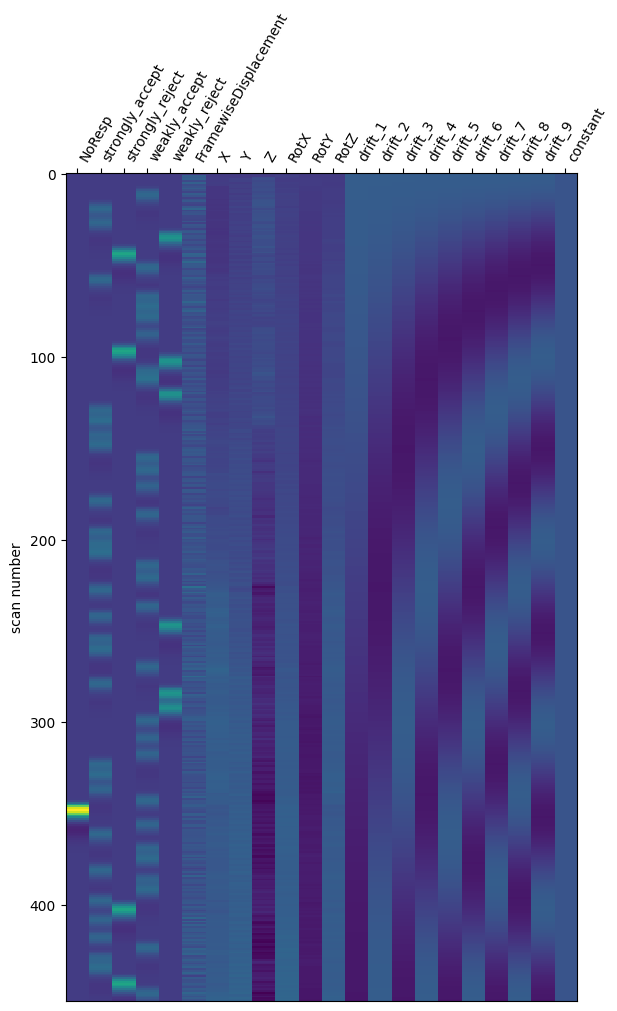

In [37]:
tr = get_tr(data_dir)

print("Getting Data")
event_file, func_file, confounds_file = get_files('sub-001', run=1)
events = pd.read_csv(event_file, sep='\t')[['participant_response', 'onset', 'duration']]
events.rename(columns = {'participant_response':'trial_type'}, inplace=True)
confounds = get_confounds(confounds_file)
confounds = confounds.fillna(0)

#Create MNI brainmask
func_img = nib.load(func_file)
mni_mask_img = nilearn.masking.compute_brain_mask(func_img)

#Fill in the following
print("Fitting Model")
first_level_model = FirstLevelModel(
    tr,
    mask_img = mni_mask_img,
    hrf_model = 'spm',
    smoothing_fwhm=5
    )
first_level_model = first_level_model.fit(func_file, events=events, confounds=confounds)
design_matrix = first_level_model.design_matrices_[0]
#show design matrix
plotting.plot_design_matrix(design_matrix)
plt.show()


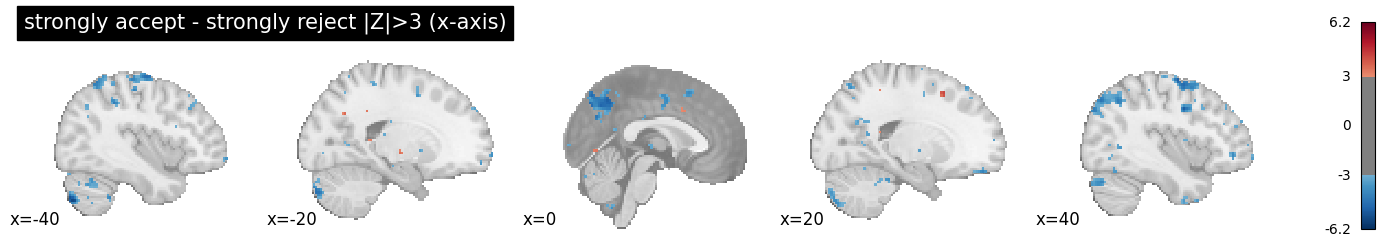

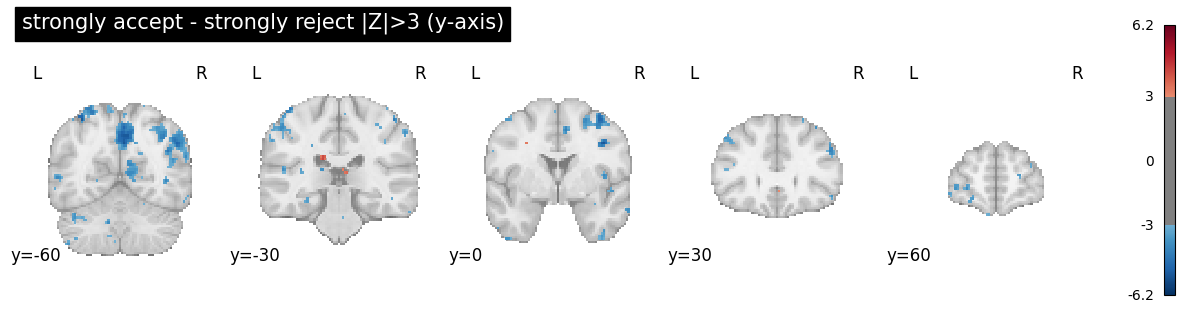

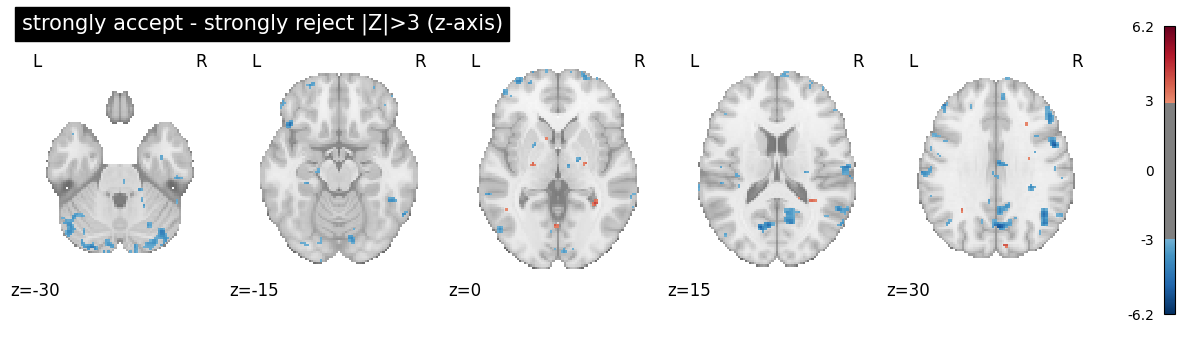

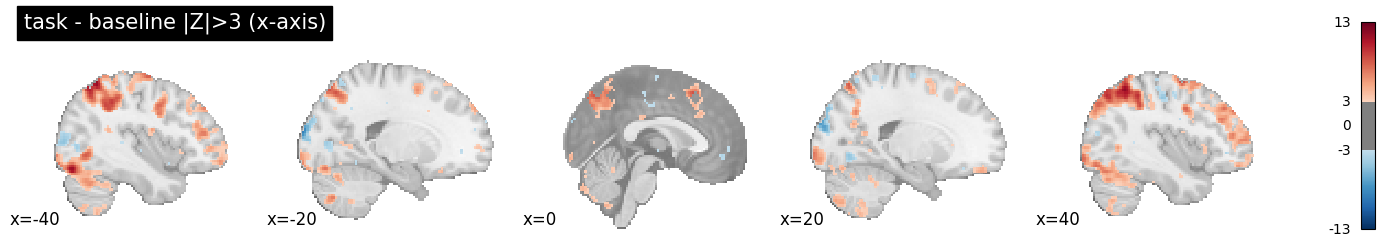

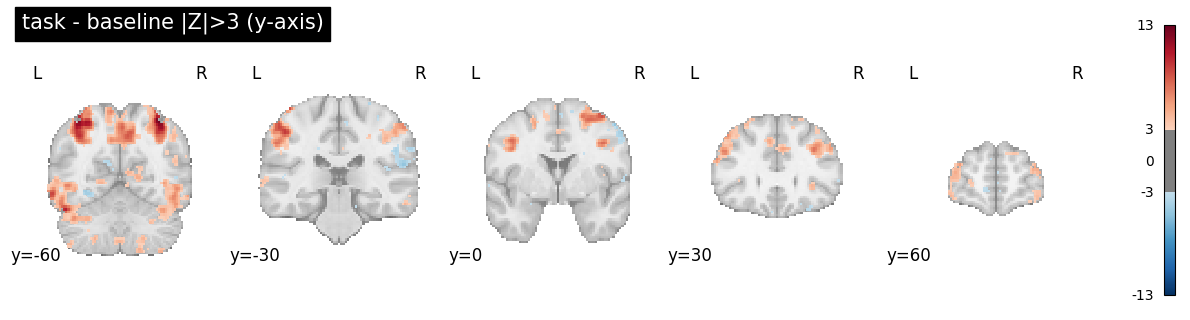

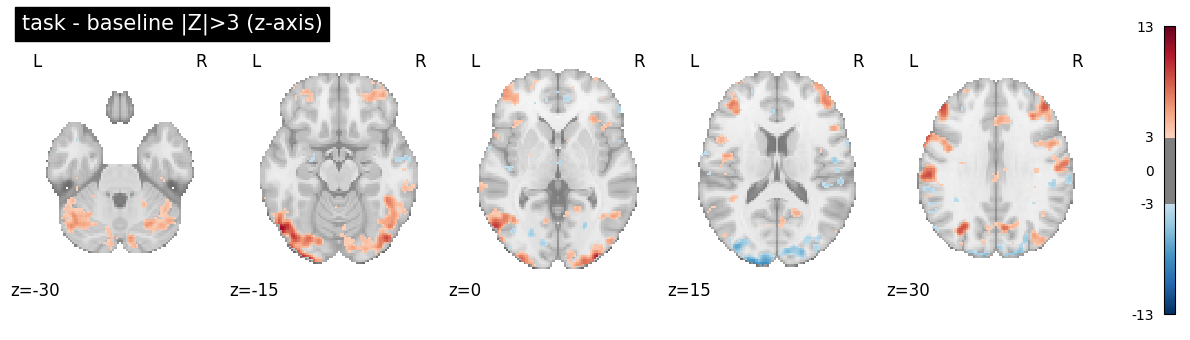

In [33]:
#Call in contrasts
contrasts = create_contrasts(design_matrix)

# Define display modes and cut coordinates for each axis
display_modes = ['x', 'y', 'z']
cut_coords = {
    'x': [-40, -20, 0, 20, 40],
    'y': [-60, -30, 0, 30, 60],
    'z': [-30, -15, 0, 15, 30]
}

#show contrast maps for each display mode
for contrast_id, contrast_val in contrasts.items():
    z_map = first_level_model.compute_contrast(
            contrast_val, output_type = 'z_score'
            )
    for mode in display_modes:
        plotting.plot_stat_map(
                z_map,
                threshold=3.0,
                title=f'{contrast_id} |Z|>3 ({mode}-axis)',
                display_mode=mode,
                cut_coords=cut_coords[mode])
        plotting.show()

Now try to run some analyses to answer the following questions.

1. Write code to get the fixed-effects map across multiple runs from the same subject. \
Hint: Refer to the nilearn tutorial page: https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_two_runs_model.html
2. Write code to run statistical analysis to identify brain activity that is statistically significant. \
Hint: Refer to the nilearn tutorial page: https://nilearn.github.io/stable/auto_examples/00_tutorials/plot_single_subject_single_run.html#statistical-significance-testing



**1. Analyze fixed-effects**

**2. Analyze statistical significance**